In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import copy
import json
import time
import pickle
from multiprocessing import Pool
from datetime import datetime
from collections import defaultdict
from abc import ABC, abstractmethod


import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from map4 import MAP4Calculator

from ga import SequenceGA, ScaffoldGA, GA
from baye import get_fitted_model, map4_fingerprint, TanimotoSimilarityKernel
from baye import AcqScoring, expected_improvement, probability_of_improvement
from helm import build_helm_string, parse_helm
from helm_genetic_operators import HELMGeneticOperators
from mhc import read_pssm_file, MHCIPeptideScorer

## Read dataset

In [3]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')
print(mhci[mhci['mhc_allele'].str.contains("HLA")]['mhc_allele'].unique().shape)

(119,)


In [4]:
# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (8 <= mhci['length']) &
            (mhci['length'] <= 11) &
            (~mhci['affinity_binding'].isin(dirty_values))]

## Genetic operators on HELM strings

In [5]:
with open('HELMCoreLibrary.json') as f:
    monomer_lib = json.load(f)

monomer_peptide_lib = [x for x in monomer_lib if x['polymerType'] == 'PEPTIDE']
AA1 = ["A", "R", "N", "D", "C", "E", "Q", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
monomer_aa1_lib = [x for x in monomer_peptide_lib if x['symbol'] in AA1]

smiles = [monomer['smiles'] for monomer in monomer_aa1_lib]
fps = map4_fingerprint(smiles,input_type='smiles', radius=2)
t = TanimotoSimilarityKernel()
similarity_matrix = t.forward(fps, fps).numpy()

probability_matrix = []

for aa in similarity_matrix:
    tmp = aa.copy()
    tmp[tmp == 1.0] = 0
    probability_matrix.append(tmp / np.sum(tmp))
    
probability_matrix = np.array(probability_matrix)

helmgo = HELMGeneticOperators(monomer_aa1_lib, probability_matrix)

In [6]:
def affinity_binding_to_energy(value, input_unit='nM', temperature=300.):
    unit_converter = {'nM': 1e-9, 'uM': 1e-6, 'mM': 1e-3, 'M': 1}
    RT = 0.001987 * temperature
    return RT * np.log(value * unit_converter[input_unit])

def energy_to_affinity_binding(value, output_unit='nM', temperature=300.):
    unit_converter = {'nM': 1e9, 'uM': 1e6, 'mM': 1e3, 'M': 1}
    RT = 0.001987 * temperature
    return np.exp(value / RT) * unit_converter[output_unit]

## Generate random peptides

In [35]:
random_peptides = []
random_peptide_scores = []

n_peptides = [150]
peptide_length = [9]
energy_bounds = [-8.235, -4.944] # about between 1 uM and 250 uM
#energy_bounds = [-4.944, -4.531] # about between 250 uM and 500 uM
#energy_bounds = [-4.531, -4.118] # about between 500 uM and 1 mM
#energy_bounds = [-8.649, -8.235] # about between 500 nM and 1uM
energy_cutoff = -4.11 # 1 mM
#energy_cutoff = -4.944 # 250 uM
#energy_cutoff = -8.235 # 1 uM

pssm_files = ['../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
mps = MHCIPeptideScorer(pssm_files, mhci, energy_cutoff=energy_cutoff)

# Generate random peptides
for n, size in zip(n_peptides, peptide_length):
    tmp_peptides, tmp_peptide_scores = mps.generate_random_peptides(n, energy_bounds, size)
    random_peptides.append(tmp_peptides)
    random_peptide_scores.append(tmp_peptide_scores)

random_peptides = np.concatenate(random_peptides)
random_peptide_scores = np.concatenate(random_peptide_scores)

clusters = defaultdict(list)
for i, sequence in enumerate(random_peptides):
    clusters[sequence.count('.')].append(i)
print('Distribution:', ['%d: %d' % (k, len(clusters[k])) for k in sorted(clusters.keys())])
print('')

print(len(random_peptides))
print(random_peptides)
print(random_peptide_scores)

----- Peptide global -----
N peptide: 8471
R2: 0.620
RMSD : 1.177 kcal/mol

Distribution: ['9: 150']

150
['PEPTIDE1{A.M.L.E.M.K.Y.V.Y}$$$$V2.0'
 'PEPTIDE1{Y.F.N.A.L.M.E.Q.I}$$$$V2.0'
 'PEPTIDE1{M.C.L.A.S.S.T.I.V}$$$$V2.0'
 'PEPTIDE1{L.Q.M.P.T.A.Q.L.T}$$$$V2.0'
 'PEPTIDE1{M.T.M.M.N.H.H.Y.C}$$$$V2.0'
 'PEPTIDE1{H.L.G.I.S.L.S.Q.M}$$$$V2.0'
 'PEPTIDE1{Q.A.Y.A.H.W.V.D.V}$$$$V2.0'
 'PEPTIDE1{K.N.A.S.I.F.H.S.L}$$$$V2.0'
 'PEPTIDE1{H.E.T.C.F.H.I.Y.V}$$$$V2.0'
 'PEPTIDE1{L.L.A.S.T.H.D.L.S}$$$$V2.0'
 'PEPTIDE1{L.S.P.L.Q.H.H.F.V}$$$$V2.0'
 'PEPTIDE1{K.Q.P.D.D.I.F.H.Q}$$$$V2.0'
 'PEPTIDE1{T.Y.G.D.V.Y.P.A.L}$$$$V2.0'
 'PEPTIDE1{F.L.H.L.Q.G.E.L.W}$$$$V2.0'
 'PEPTIDE1{W.F.D.N.P.F.F.H.M}$$$$V2.0'
 'PEPTIDE1{L.I.F.T.R.T.C.S.S}$$$$V2.0'
 'PEPTIDE1{F.W.L.A.G.W.N.E.W}$$$$V2.0'
 'PEPTIDE1{G.Q.R.G.M.H.T.R.V}$$$$V2.0'
 'PEPTIDE1{G.Y.Y.G.Y.Q.W.P.P}$$$$V2.0'
 'PEPTIDE1{G.V.F.E.K.V.Q.V.F}$$$$V2.0'
 'PEPTIDE1{K.H.F.W.V.N.F.Y.S}$$$$V2.0'
 'PEPTIDE1{C.C.I.K.V.C.M.D.V}$$$$V2.0'
 'PEPTIDE1{M.N.F.S.N.M.P.N.M}$$$$V2.

In [8]:
candidates = random_peptides.copy()
candidate_scores = random_peptide_scores.copy()


X_fps_exp = map4_fingerprint(candidates, input_type='helm')
y_exp = torch.from_numpy(candidate_scores).float()


model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)
scoring_function = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm', greater_is_better=False)

In [21]:
parameters = {'n_gen': 30, 'n_children': 1000, 'temperature': 0.025, 'elitism': True, 'tolerance': 1e-3}
gao = SequenceGA(helmgo, **parameters)
seq, scores = gao.run(scoring_function, candidates, candidate_scores)

999.000 -8.119 1007.119
N 1 sequence opt - Score: -0.298 - Seq: 9 - PEPTIDE1{Y.L.M.C.I.H.V.A.I}$$$$V2.0
-8.119 -0.171 7.949
N 2 sequence opt - Score: -0.372 - Seq: 9 - PEPTIDE1{Y.L.M.C.C.H.V.A.I}$$$$V2.0
-0.171 -0.287 0.117
N 3 sequence opt - Score: -0.421 - Seq: 9 - PEPTIDE1{Y.L.M.L.I.A.V.A.I}$$$$V2.0
-0.287 -0.345 0.058
N 4 sequence opt - Score: -0.460 - Seq: 9 - PEPTIDE1{Y.L.M.L.V.A.V.A.I}$$$$V2.0
-0.345 -0.391 0.046
N 5 sequence opt - Score: -0.489 - Seq: 9 - PEPTIDE1{Y.L.M.L.V.A.C.A.I}$$$$V2.0
-0.391 -0.411 0.020
N 6 sequence opt - Score: -0.496 - Seq: 9 - PEPTIDE1{F.L.M.L.V.V.L.A.I}$$$$V2.0
-0.411 -0.432 0.021
N 7 sequence opt - Score: -0.506 - Seq: 9 - PEPTIDE1{F.L.M.L.A.V.L.A.I}$$$$V2.0
-0.432 -0.441 0.008
N 8 sequence opt - Score: -0.531 - Seq: 9 - PEPTIDE1{F.L.M.A.A.V.L.A.I}$$$$V2.0
-0.441 -0.451 0.011
N 9 sequence opt - Score: -0.531 - Seq: 9 - PEPTIDE1{F.L.M.A.A.V.L.A.I}$$$$V2.0
-0.451 -0.456 0.004
N 10 sequence opt - Score: -0.531 - Seq: 9 - PEPTIDE1{F.L.M.A.A.V.L.A.I}$$$$

In [22]:
seq

array(['PEPTIDE1{F.L.M.A.G.V.L.A.I}$$$$V2.0',
       'PEPTIDE1{Y.L.M.L.G.V.L.A.I}$$$$V2.0',
       'PEPTIDE1{F.L.M.L.G.V.L.A.I}$$$$V2.0', ...,
       'PEPTIDE1{C.V.V.W.G.N.Q.W.P}$$$$V2.0',
       'PEPTIDE1{C.V.V.W.G.N.Q.W.D}$$$$V2.0',
       'PEPTIDE1{C.V.V.W.G.N.Q.W.R}$$$$V2.0'], dtype='<U35')

In [124]:
random_peptide = 'PEPTIDE1{A.R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,8:R3-3:R3$$$V2.0'
c = helmgo.insert(random_peptide, only_terminus=False, maximum_size=12)

for i in c:
    print(i, i.count('.'))

PEPTIDE1{A.R.C.A.A.P.K.T.C.D}$PEPTIDE1,PEPTIDE1,9:R3-3:R3$$$V2.0 10
PEPTIDE1{A.R.Y.C.A.G.A.K.T.C.S.D}$PEPTIDE1,PEPTIDE1,10:R3-4:R3$$$V2.0 12
PEPTIDE1{R.A.R.R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,10:R3-5:R3$$$V2.0 11
PEPTIDE1{A.W.L.R.C.I.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,11:R3-5:R3$$$V2.0 12
PEPTIDE1{A.R.C.A.A.K.R.T.C.D}$PEPTIDE1,PEPTIDE1,9:R3-3:R3$$$V2.0 10
PEPTIDE1{A.R.C.A.A.K.R.A.T.G.C.D}$PEPTIDE1,PEPTIDE1,11:R3-3:R3$$$V2.0 12
PEPTIDE1{A.R.C.A.A.Y.K.T.C.N.D}$PEPTIDE1,PEPTIDE1,9:R3-3:R3$$$V2.0 11
PEPTIDE1{A.H.R.C.A.P.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,10:R3-4:R3$$$V2.0 11
PEPTIDE1{A.R.C.R.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,9:R3-3:R3$$$V2.0 10
PEPTIDE1{A.R.C.R.A.A.Y.K.T.S.C.D}$PEPTIDE1,PEPTIDE1,11:R3-3:R3$$$V2.0 12


In [151]:
random_peptide = 'PEPTIDE1{A.R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,8:R3-3:R3$$$V2.0'
c = helmgo.delete(random_peptide, only_terminus=True, minimum_size=6, keep_connections=False)

for i in c:
    print(i, i.count('.'))

PEPTIDE1{A.R.C.A.A.K.T.C}$PEPTIDE1,PEPTIDE1,8:R3-3:R3$$$V2.0 8
PEPTIDE1{R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,7:R3-2:R3$$$V2.0 8
PEPTIDE1{A.R.C.A.A.K.T.C}$PEPTIDE1,PEPTIDE1,8:R3-3:R3$$$V2.0 8
PEPTIDE1{R.C.A.A.K.T.C}$PEPTIDE1,PEPTIDE1,7:R3-2:R3$$$V2.0 7
PEPTIDE1{R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,7:R3-2:R3$$$V2.0 8
PEPTIDE1{R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,7:R3-2:R3$$$V2.0 8
PEPTIDE1{R.C.A.A.K.T.C.D}$PEPTIDE1,PEPTIDE1,7:R3-2:R3$$$V2.0 8
PEPTIDE1{A.R.C.A.A.K.T.C}$PEPTIDE1,PEPTIDE1,8:R3-3:R3$$$V2.0 8
PEPTIDE1{A.R.C.A.A.K.T.C}$PEPTIDE1,PEPTIDE1,8:R3-3:R3$$$V2.0 8
PEPTIDE1{R.C.A.A.K.T.C}$PEPTIDE1,PEPTIDE1,7:R3-2:R3$$$V2.0 7


In [32]:
class DMTExperience:
    
    def __init__(self, init_population, init_scores):
        self._init_pop = init_population
        self._init_scores = init_scores
        
    def run(self, n_step=3, n_sample=10, **config):        
        data = []
        NCAN = config['NCAN']

        helmgo = config['helmgo']
        config.pop('helmgo')
        
        # Add initial data
        for seq, exp_score in zip(self._init_pop, self._init_scores):
            data.append((0, 0, exp_score, np.nan, seq.count('.'), seq))

        for i in range(n_sample):
            print('Run: %s' % (i + 1))
            
            # Defined local and global GA optimization
            gao = SequenceGA(helmgo, **config)

            # We want to keep a copy of the random peptides generated
            candidates = self._init_pop.copy()
            candidate_scores = self._init_scores.copy()

            # Compute the MAP4 fingerprint for all the peptides
            X_fps_exp = map4_fingerprint(candidates, input_type='helm')
            y_exp = torch.from_numpy(candidate_scores).float()
            print('Exp dataset size: (%d, %d)' % (X_fps_exp.shape[0], X_fps_exp.shape[1]))

            print('\n')
            print('Init.')
            print('N pep: ', X_fps_exp.shape[0])
            print('Best peptide: %.3f' % y_exp.min())
            for n in [-13, -12, -11, -10, -9, -8]:
                print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
            print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
            print('\n')

            for j in range(n_step):
                print('Generation: %d' % (j + 1))
                
                # Fit GP model
                model = get_fitted_model(X_fps_exp, y_exp, kernel=TanimotoSimilarityKernel)

                # Initialize acquisition function
                #acq = AcqScoring(model, probability_of_improvement, y_exp, sequence_type='helm', greater_is_better=True)
                scoring_function = AcqScoring(model, expected_improvement, y_exp, sequence_type='helm', greater_is_better=False)

                # Find new candidates using GA optimization
                gao.run(scoring_function, candidates, candidate_scores)

                # Take NCAN (96) best candidates found
                candidate_sequences = gao.sequences[:NCAN]
                candidates_acq = gao.scores[:NCAN]

                clusters = defaultdict(list)
                for i_seq, sequence in enumerate(candidate_sequences):
                    clusters[sequence.count('.')].append(i_seq)
                print('Final selection:', ['%d: %d' % (k, len(v)) for k, v in clusters.items()])

                # Get affinitiy binding values (MAKE TEST)
                candidate_sequences_fasta = [''.join(c.split('$')[0].split('{')[1].split('}')[0].split('.')) for c in candidate_sequences]
                y_candidates = mps.predict_energy(candidate_sequences_fasta)

                # Add candidates to the training set
                candidates = np.append(candidates, candidate_sequences)
                candidate_scores = np.append(candidate_scores, y_candidates)
                candidate_fps = map4_fingerprint(candidate_sequences, input_type='helm')

                X_fps_exp = torch.cat([X_fps_exp, candidate_fps])
                y_exp = torch.cat([y_exp, torch.from_numpy(y_candidates)])
                
                print('')
                print('N pep: ', X_fps_exp.shape[0])
                print('Best peptide: %.3f' % y_exp.min())
                for n in [-13, -12, -11, -10, -9, -8]:
                    print('N pep under %d kcal/mol: %03d' % (n, y_exp[y_exp < n].shape[0]))
                print('Non binding pep        : %03d' % (y_exp[y_exp == 0.].shape[0]))
                print('')
                
                # Store data
                for seq, acq_score, exp_score in zip(candidate_sequences, candidates_acq, y_candidates):
                    data.append((i + 1, j + 1, exp_score, acq_score, seq.count('.'), seq))
        
        columns = ['sample', 'gen', 'exp_score', 'acq_score', 'length', 'sequence']
        df = pd.DataFrame(data=data, columns=columns)
        
        return df        

In [10]:
parameters = {'NCAN': 96,
              'n_gen': 1, 'helmgo': helmgo,
              'sequence_n_gen': 10, 'sequence_n_children': 500, 'sequence_sigma': 0.1, 'sequence_elitism': True, 'sequence_n_process': 4,
              'scaffold_n_gen': 1, 'scaffold_n_children': 1000, 'scaffold_sigma': 0.5, 'scaffold_elitism': True,
              'scaffold_probability': 0.25, 'scaffold_only_terminus': True, 'scaffold_minimum_size': 8, 'scaffold_maximum_size': 11}

dmt = DMTExperience(random_peptides, random_peptide_scores)
df = dmt.run(4, 10, **parameters)

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.158
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 002
Non binding pep        : 000


Generation: 1
End scaffold opt - Score: -0.011 - Seq: 9 - PEPTIDE1{F.W.Q.I.F.N.L.N.M}$$$$V2.0
End sequence opt - Score: -0.014 - Seq: 9 - PEPTIDE1{F.W.M.C.F.N.L.N.M}$$$$V2.0
End sequence opt - Score: -0.011 - Seq: 8 - PEPTIDE1{W.F.C.F.N.M.C.I}$$$$V2.0
End sequence opt - Score: -0.015 - Seq: 10 - PEPTIDE1{W.F.L.C.N.M.V.I.L.V}$$$$V2.0
End sequence opt - Score: -0.018 - Seq: 11 - PEPTIDE1{F.F.F.L.M.F.I.I.L.L.V}$$$$V2.0
End GA opt - Score: -0.018 - Seq: 11 - PEPTIDE1{F.F.F.L.M.F.I.I.L.L.V}$$$$V2.0
57.73698592185974
Final selection: ['11: 94', '10: 2']

N pep:  246
Best peptide: -9.647
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep

End scaffold opt - Score: -0.014 - Seq: 10 - PEPTIDE1{F.L.I.M.F.V.I.F.G.V}$$$$V2.0
End sequence opt - Score: -0.000 - Seq: 8 - PEPTIDE1{M.M.L.F.I.Y.W.V}$$$$V2.0
End sequence opt - Score: -0.001 - Seq: 9 - PEPTIDE1{L.M.L.F.F.I.F.W.V}$$$$V2.0
End sequence opt - Score: -0.047 - Seq: 10 - PEPTIDE1{F.L.M.M.F.V.I.F.F.V}$$$$V2.0
End sequence opt - Score: -0.000 - Seq: 11 - PEPTIDE1{F.L.M.M.F.V.I.F.W.V.T}$$$$V2.0
End GA opt - Score: -0.047 - Seq: 10 - PEPTIDE1{F.L.M.M.F.V.I.F.F.V}$$$$V2.0
49.845787048339844
Final selection: ['10: 96']

N pep:  438
Best peptide: -13.169
N pep under -13 kcal/mol: 001
N pep under -12 kcal/mol: 075
N pep under -11 kcal/mol: 190
N pep under -10 kcal/mol: 224
N pep under -9 kcal/mol: 229
N pep under -8 kcal/mol: 288
Non binding pep        : 000

Generation: 4
End scaffold opt - Score: -0.006 - Seq: 10 - PEPTIDE1{F.L.M.M.F.L.L.F.F.V}$$$$V2.0


Process ForkPoolWorker-46:
Traceback (most recent call last):
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/multiprocessing/pool.py", line 47, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
Process ForkPoolWorker-47:


KeyboardInterrupt: 

  File "/home/eberhardt/Documents/mobius/data/helm_ga/ga.py", line 156, in run
    self.sequences, self.scores = super().run(scoring_function, sequences, scores)
  File "/home/eberhardt/Documents/mobius/data/helm_ga/ga.py", line 108, in run
    scores = self._scoring_function.evaluate(sequences)
  File "/home/eberhardt/Documents/mobius/data/helm_ga/baye.py", line 126, in evaluate
    fps = map4_fingerprint(sequences, self._sequence_type)
Process ForkPoolWorker-45:
  File "/home/eberhardt/Documents/mobius/data/helm_ga/baye.py", line 109, in map4_fingerprint
    fps = MAP4_unf.calculate_many([f[input_type](s) for s in molecule_strings])
Traceback (most recent call last):
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/map4/map4.py", line 64, in calculate_many
    return [self._fold(pairs) for pairs in atom_env_pairs_list]
  File "/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/map4/map4.py", line 64, in <listcomp>


In [67]:
parameters = {'NCAN': 96, 'helmgo': helmgo,
              'n_gen': 100, 'n_children': 1000, 'temperature': 0.025, 'elitism': True, 'tolerance': 1e-3, 'total_attempts': 10}

dmt = DMTExperience(random_peptides, random_peptide_scores)
df = dmt.run(4, 10, **parameters)

Run: 1
Exp dataset size: (150, 4096)


Init.
N pep:  150
Best peptide: -8.230
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 000
N pep under -10 kcal/mol: 000
N pep under -9 kcal/mol: 000
N pep under -8 kcal/mol: 004
Non binding pep        : 000


Generation: 1
999.000 -8.151 1007.151
999.000 -8.230 - 0/10
N 1 sequence opt - Score: -0.096 - Seq: 9 - PEPTIDE1{M.C.L.A.S.S.T.I.V}$$$$V2.0
-8.151 -0.031 8.120
-8.230 -0.096 - 0/10
N 2 sequence opt - Score: -0.141 - Seq: 9 - PEPTIDE1{M.C.L.A.S.S.S.I.V}$$$$V2.0
-0.031 -0.063 0.032
-0.096 -0.141 - 0/10
N 3 sequence opt - Score: -0.144 - Seq: 9 - PEPTIDE1{M.L.L.A.S.S.S.I.V}$$$$V2.0
-0.063 -0.091 0.027
-0.141 -0.144 - 0/10
N 4 sequence opt - Score: -0.149 - Seq: 9 - PEPTIDE1{M.A.L.A.S.S.V.L.V}$$$$V2.0
-0.091 -0.110 0.019
-0.144 -0.149 - 0/10
N 5 sequence opt - Score: -0.158 - Seq: 9 - PEPTIDE1{M.A.L.A.S.C.V.L.V}$$$$V2.0
-0.110 -0.116 0.006
-0.149 -0.158 - 0/10
N 6 sequence opt - Score: -0.158 - Seq: 9 - PEPT

N 10 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.123 -0.132 0.009
-0.160 -0.161 - 0/10
N 11 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.132 -0.126 0.006
-0.161 -0.161 - 1/10
N 12 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.126 -0.135 0.009
-0.161 -0.161 - 2/10
N 13 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.135 -0.128 0.008
-0.161 -0.161 - 3/10
N 14 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.128 -0.137 0.010
-0.161 -0.161 - 4/10
N 15 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.137 -0.130 0.007
-0.161 -0.161 - 5/10
N 16 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.130 -0.140 0.009
-0.161 -0.161 - 6/10
N 17 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.140 -0.133 0.006
-0.161 -0.161 - 7/10
N 18 sequence opt - Scor

N 12 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.124 -0.135 0.011
-0.161 -0.161 - 1/10
N 13 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.135 -0.128 0.007
-0.161 -0.161 - 2/10
N 14 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.128 -0.137 0.010
-0.161 -0.161 - 3/10
N 15 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.137 -0.128 0.009
-0.161 -0.161 - 4/10
N 16 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.128 -0.140 0.011
-0.161 -0.161 - 5/10
N 17 sequence opt - Score: -0.162 - Seq: 9 - PEPTIDE1{L.L.M.S.S.V.L.L.V}$$$$V2.0
-0.140 -0.134 0.006
-0.161 -0.162 - 0/10
N 18 sequence opt - Score: -0.162 - Seq: 9 - PEPTIDE1{L.L.M.S.S.V.L.L.V}$$$$V2.0
-0.134 -0.139 0.006
-0.162 -0.162 - 1/10
N 19 sequence opt - Score: -0.162 - Seq: 9 - PEPTIDE1{L.L.M.S.S.V.L.L.V}$$$$V2.0
-0.139 -0.133 0.007
-0.162 -0.162 - 2/10
N 20 sequence opt - Scor

N 1 sequence opt - Score: -0.117 - Seq: 9 - PEPTIDE1{M.C.L.A.S.S.I.I.V}$$$$V2.0
-8.151 -0.032 8.119
-8.230 -0.117 - 0/10
N 2 sequence opt - Score: -0.130 - Seq: 9 - PEPTIDE1{M.C.L.A.S.S.V.I.V}$$$$V2.0
-0.032 -0.078 0.046
-0.117 -0.130 - 0/10
N 3 sequence opt - Score: -0.141 - Seq: 9 - PEPTIDE1{M.C.L.A.S.S.V.V.V}$$$$V2.0
-0.078 -0.092 0.015
-0.130 -0.141 - 0/10
N 4 sequence opt - Score: -0.141 - Seq: 9 - PEPTIDE1{M.C.L.A.S.S.V.V.V}$$$$V2.0
-0.092 -0.101 0.009
-0.141 -0.141 - 1/10
N 5 sequence opt - Score: -0.146 - Seq: 9 - PEPTIDE1{M.C.L.V.S.S.V.V.V}$$$$V2.0
-0.101 -0.106 0.005
-0.141 -0.146 - 0/10
N 6 sequence opt - Score: -0.146 - Seq: 9 - PEPTIDE1{M.C.L.V.S.S.V.V.V}$$$$V2.0
-0.106 -0.111 0.005
-0.146 -0.146 - 1/10
N 7 sequence opt - Score: -0.157 - Seq: 9 - PEPTIDE1{M.L.L.V.S.V.V.V.V}$$$$V2.0
-0.111 -0.117 0.006
-0.146 -0.157 - 0/10
N 8 sequence opt - Score: -0.157 - Seq: 9 - PEPTIDE1{M.L.L.V.S.V.V.V.V}$$$$V2.0
-0.117 -0.117 0.000
-0.157 -0.157 - 1/10
Parents population converged!
En

N 11 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.126 -0.135 0.009
-0.161 -0.161 - 3/10
N 12 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.135 -0.128 0.006
-0.161 -0.161 - 4/10
N 13 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.128 -0.138 0.010
-0.161 -0.161 - 5/10
N 14 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.138 -0.132 0.006
-0.161 -0.161 - 6/10
N 15 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.132 -0.137 0.005
-0.161 -0.161 - 7/10
N 16 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.137 -0.131 0.006
-0.161 -0.161 - 8/10
N 17 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.131 -0.139 0.009
-0.161 -0.161 - 9/10
N 18 sequence opt - Score: -0.161 - Seq: 9 - PEPTIDE1{M.L.L.A.S.V.V.L.V}$$$$V2.0
-0.139 -0.132 0.007
-0.161 -0.161 - 10/10
N 19 sequence opt - Sco


N pep:  342
Best peptide: -11.885
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 000
N pep under -11 kcal/mol: 106
N pep under -10 kcal/mol: 141
N pep under -9 kcal/mol: 149
N pep under -8 kcal/mol: 184
Non binding pep        : 000

Generation: 3
999.000 -11.105 1010.105
999.000 -11.885 - 0/10
N 1 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.L.A.C.I.I.L.V}$$$$V2.0
-11.105 -0.002 11.103
-11.885 -0.046 - 0/10
N 2 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.L.A.C.I.I.L.V}$$$$V2.0
-0.002 -0.007 0.005
-0.046 -0.046 - 1/10
N 3 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.L.A.C.I.I.L.V}$$$$V2.0
-0.007 -0.003 0.003
-0.046 -0.046 - 2/10
N 4 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.L.A.C.I.I.L.V}$$$$V2.0
-0.003 -0.009 0.006
-0.046 -0.046 - 3/10
N 5 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.L.A.C.I.I.L.V}$$$$V2.0
-0.009 -0.005 0.004
-0.046 -0.046 - 4/10
N 6 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.L.A.C.I.I.L.V}$$$$V2.0
-0.005 

N 8 sequence opt - Score: -0.043 - Seq: 9 - PEPTIDE1{M.L.M.A.C.I.I.L.V}$$$$V2.0
-0.001 -0.029 0.028
-0.043 -0.043 - 1/10
N 9 sequence opt - Score: -0.043 - Seq: 9 - PEPTIDE1{M.L.M.A.C.I.I.L.V}$$$$V2.0
-0.029 -0.014 0.015
-0.043 -0.043 - 2/10
N 10 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.014 -0.001 0.013
-0.043 -0.046 - 0/10
N 11 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.001 -0.032 0.031
-0.046 -0.046 - 1/10
N 12 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.032 -0.016 0.017
-0.046 -0.046 - 2/10
N 13 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.016 -0.002 0.014
-0.046 -0.046 - 3/10
N 14 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.002 -0.032 0.031
-0.046 -0.046 - 4/10
N 15 sequence opt - Score: -0.046 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.032 -0.016 0.016
-0.046 -0.046 - 5/10
N 16 sequence opt - Score:

N 10 sequence opt - Score: -0.072 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.007 -0.024 0.017
-0.072 -0.072 - 9/10
N 11 sequence opt - Score: -0.072 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.024 -0.009 0.015
-0.072 -0.072 - 10/10
N 12 sequence opt - Score: -0.072 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
-0.009 -0.017 0.008
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.071909 - Seq: 9 - PEPTIDE1{M.L.M.A.C.V.I.L.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  438
Best peptide: -12.412
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 100
N pep under -11 kcal/mol: 221
N pep under -10 kcal/mol: 253
N pep under -9 kcal/mol: 271
N pep under -8 kcal/mol: 290
Non binding pep        : 000

Generation: 4
999.000 -11.571 1010.571
999.000 -12.412 - 0/10
N 1 sequence opt - Score: -0.006 - Seq: 9 - PEPTIDE1{M.L.M.A.C.I.I.L.V}$$$$V2.0
-11.571 -0.000 11.571
-12.412 -0.006 - 0/10
N 2 sequence opt - Score: -0.006 - Seq: 9 - PEPTIDE1{M.L.M.A.C.I

999.000 -12.168 1011.168
999.000 -12.457 - 0/10
N 1 sequence opt - Score: -0.019 - Seq: 9 - PEPTIDE1{M.L.M.G.C.L.I.L.V}$$$$V2.0
-12.168 -0.000 12.168
-12.457 -0.019 - 0/10
N 2 sequence opt - Score: -0.019 - Seq: 9 - PEPTIDE1{M.L.M.G.C.L.I.L.V}$$$$V2.0
-0.000 -0.019 0.019
-0.019 -0.019 - 1/10
N 3 sequence opt - Score: -0.019 - Seq: 9 - PEPTIDE1{M.L.M.G.C.L.I.L.V}$$$$V2.0
-0.019 -0.009 0.009
-0.019 -0.019 - 2/10
N 4 sequence opt - Score: -0.027 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.009 -0.001 0.009
-0.019 -0.027 - 0/10
N 5 sequence opt - Score: -0.027 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.001 -0.009 0.008
-0.027 -0.027 - 1/10
N 6 sequence opt - Score: -0.027 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.009 -0.005 0.004
-0.027 -0.027 - 2/10
N 7 sequence opt - Score: -0.027 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.005 -0.000 0.004
-0.027 -0.027 - 3/10
N 8 sequence opt - Score: -0.027 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.000 -0.027 0.027
-0

N 7 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.011 -0.001 0.011
-0.023 -0.023 - 6/10
N 8 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.001 -0.010 0.010
-0.023 -0.023 - 7/10
N 9 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.010 -0.006 0.005
-0.023 -0.023 - 8/10
N 10 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.006 -0.000 0.005
-0.023 -0.023 - 9/10
N 11 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.000 -0.023 0.022
-0.023 -0.023 - 10/10
N 12 sequence opt - Score: -0.023 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
-0.023 -0.011 0.011
Parents population converged! (optimization stuck)
End sequence opt - Score: -0.022510 - Seq: 9 - PEPTIDE1{M.L.M.G.C.I.I.L.V}$$$$V2.0
Final selection: ['9: 96']

N pep:  534
Best peptide: -12.457
N pep under -13 kcal/mol: 000
N pep under -12 kcal/mol: 181
N pep under -11 kcal/mol: 311
N pep

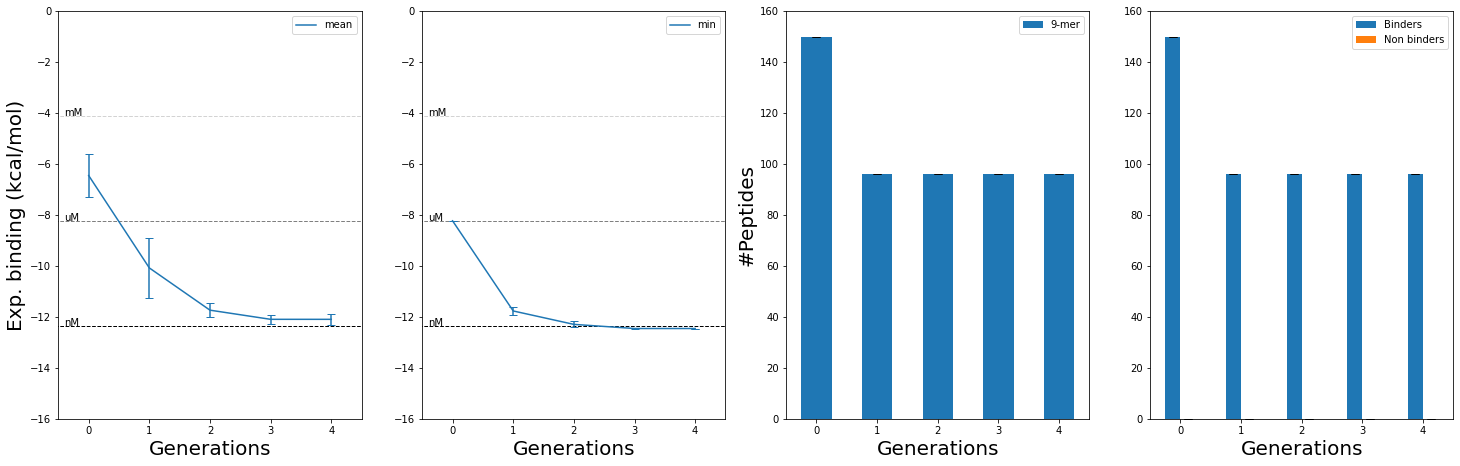

In [68]:
fig, axarr = plt.subplots(1, 4, sharex=True, figsize=(25, 7.5))

for i in range(2):
    x = [-1, 0, 1, 2, 3, 4, 5]
    axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='mM')] * len(x), '--', linewidth=1, color='lightgray')
    axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='uM')] * len(x), '--', linewidth=1, color='gray')
    axarr[i].plot(x, [affinity_binding_to_energy(1, input_unit='nM')] * len(x), '--', linewidth=1, color='black')
    axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='mM'), 'mM')
    axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='uM'), 'uM')
    axarr[i].text(-0.4, affinity_binding_to_energy(1, input_unit='nM'), 'nM')

# Average
df.replace({'exp_score': 0.}, np.nan)\
  .groupby(by=['gen'])['exp_score']\
  .agg(['mean', 'std'])\
  .reset_index()\
  .plot(x='gen', y='mean', yerr='std', ax=axarr[0], capsize=4, rot=0, fontsize=10, color='tab:blue')

# Min
y = df.groupby(by=['gen'])['exp_score']\
  .agg(['min'])\
  .reset_index()

errors = df.groupby(by=['sample', 'gen'])['exp_score']\
  .agg(['min'])\
  .reset_index()\
  .groupby(by=['gen'])['min']\
  .agg(['std'])\
  .fillna(0)\
  .reset_index()

y.plot(x='gen', yerr=errors['std'], ax=axarr[1], capsize=4, rot=0, fontsize=10, color='tab:blue')

# Length
y = df.groupby(by=['sample', 'gen', 'length'])\
  .agg(['count'])['exp_score']\
  .groupby(['gen', 'length'])\
  .mean()\
  .fillna(0)\
  .pivot_table(['count'], ['gen'], 'length')\
  .reset_index()\
  .fillna(0)

# fillna(0) to avoid NaN otherwise removed when pivoting...
errors = df.groupby(by=['sample', 'gen', 'length'])\
  .agg(['count'])['exp_score']\
  .groupby(['gen', 'length'])\
  .std()\
  .fillna(0)\
  .pivot_table(['count'], ['gen'], 'length')\
  .reset_index()\
  .fillna(0)

y.plot.bar(x='gen', yerr=errors, ax=axarr[2], capsize=4, rot=0, fontsize=10)

# Binders and non binders
data_mean = []
data_errors = []

for gen, gen_group in df.groupby(by='gen'):
    n_sample = gen_group['sample'].unique().shape[0]
    
    mean_binders = gen_group[gen_group['exp_score'] != 0].shape[0] / n_sample
    mean_nonbinders = gen_group[gen_group['exp_score'] == 0].shape[0] / n_sample
    
    tmp_binders = []
    tmp_nonbinders = []
    for sample, sample_group in gen_group.groupby(by='sample'):
        tmp_binders.append(sample_group[sample_group['exp_score'] != 0].shape[0])
        tmp_nonbinders.append(sample_group[sample_group['exp_score'] == 0].shape[0])
        
    std_binders = np.std(tmp_binders)
    std_nonbinders = np.std(tmp_nonbinders)
    
    data_mean.append((gen, mean_binders, mean_nonbinders))
    data_errors.append((gen, std_binders, std_nonbinders))
    
df_mean_binders = pd.DataFrame(data=data_mean, columns=('gen', 'binders', 'non_binders'))
df_errors_binders = pd.DataFrame(data=data_errors, columns=('gen', 'binders', 'non_binders'))
df_mean_binders.plot.bar(x='gen', y=['binders', 'non_binders'], yerr=df_errors_binders, ax=axarr[3], capsize=4, rot=0, fontsize=10)


axarr[0].set_xlabel('Generations', fontsize=20)
axarr[1].set_xlabel('Generations', fontsize=20)
axarr[2].set_xlabel('Generations', fontsize=20)
axarr[3].set_xlabel('Generations', fontsize=20)
axarr[0].set_ylabel('Exp. binding (kcal/mol)', fontsize=20)
axarr[2].set_ylabel('#Peptides', fontsize=20)

axarr[0].set_ylim([-16, 0])
axarr[1].set_ylim([-16, 0])
axarr[2].set_ylim([0, 160])
axarr[3].set_ylim([0, 160])

#axarr[0].legend(['Mean'], fontsize=15)
#axarr[1].legend(['Min'], fontsize=15)
axarr[2].legend(['%d-mer' % s for s in np.sort(df['length'].unique())], fontsize=10)
axarr[3].legend(['Binders', 'Non binders'], fontsize=10)

date = datetime.now().strftime("%d-%m-%Y_%H:%M")
#run_name = '%s_150-9-mers_500nM-1uM-1uM_G4-1000-0.5_L10-500-0.1_8-to-11-mers_pi' % date
run_name = 'test_2'
df.to_csv('data_%s.csv' % run_name, index=False)
plt.savefig('figure_%s.png' % run_name, dpi=300, bbox_inches='tight')
plt.show()